In [1]:
# uncomment and install if needed
# %pip install opencv-python
# %pip install python-dotenv
# %pip install azure-ai-formrecognizer

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: python-dotenv in c:\users\wawilk\appdata\roaming\python\python39\site-packages (1.0.0)




[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import openai
from typing import List
from dotenv import load_dotenv
# get env variables from .env file
load_dotenv()
#
# now we will set local vars from the env variables
#
# *****************************************
# Configure OpenAI API
# *****************************************
openai.api_type = "azure"
openai.api_version = os.getenv("AZURE_OPENAI_API_VERSION")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_key = os.getenv("AZURE_OPENAI_KEY")
llm_model = os.getenv("AZURE_OPENAI_MODEL")
#
# *****************************************
# Configure OpenAI Orchestrator
# *****************************************
llm_max_tokens = os.getenv("AZURE_OPENAI_MAX_TOKENS")
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")
#
# *****************************************
# Configure Document Intelligence API
# *****************************************
sas_key = os.getenv("AZURE_BLOB_ACCOUNT_SAS_KEY")
form_recognizer_key = os.getenv("AZURE_FORM_RECOGNIZER_KEY")
form_recognizer_endpoint = os.getenv("AZURE_FORM_RECOGNIZER_ENDPOINT")
storage_account_url = os.getenv("AZURE_BLOB_ACCOUNT_URL")
container_name=os.getenv("AZURE_BLOB_CONTAINER_NAME")
test_document_name=os.getenv("TEST_DOCUMENT_NAME")
#
# Just for checking, print out a couple of values#
# print(sas_key)
# print(openai.api_type)
# print(openai.api_version)
# print(openai.api_base)
# print(openai.api_key)
# print(llm_model)
# print(llm_max_tokens)
# print(embedding_model)
# print(form_recognizer_key)
# print(form_recognizer_endpoint)
# print(storage_account_url)
# print(container_name)
# print(test_document_name)

### create some functions I may need

In [2]:
#
import cv2 
import numpy as np
#
def get_content(pdf_document, pages_to_ocr):
    import os
    from azure.ai.formrecognizer import DocumentAnalysisClient
    from azure.core.credentials import AzureKeyCredential

    # Put the endpoint and key values in the .env file
    endpoint = os.getenv('AZURE_FORM_RECOGNIZER_ENDPOINT', '')
    key =  os.getenv('AZURE_FORM_RECOGNIZER_KEY', '')
    #
    print("endpoint: " + endpoint)
    print("key: " + key)
    document_analysis_client = DocumentAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(key))
    model="prebuilt-layout"
    #model="prebuilt-document"
    #
    # call the Document Intelligence API
    with open(pdf_document, "rb") as f:
        poller = document_analysis_client.begin_analyze_document(model, document=f, locale="en-US", pages=pages_to_ocr)
    #
    # return  the result
    result = poller.result()
    return result


# tuplify
def tup(point):
    return (point[0], point[1]);

# returns true if the two boxes overlap
def overlap(source, target):
    # unpack points
    tl1, br1 = source;
    tl2, br2 = target;

    # checks
    if (tl1[0] >= br2[0] or tl2[0] >= br1[0]):
        return False;
    if (tl1[1] >= br2[1] or tl2[1] >= br1[1]):
        return False;
    return True;

# returns all overlapping boxes
def getAllOverlaps(boxes, bounds, index):
    overlaps = [];
    for a in range(len(boxes)):
        if a != index:
            if overlap(bounds, boxes[a]):
                overlaps.append(a);
    return overlaps;

def medianCanny(img, thresh1, thresh2):
    median = np.median(img)
    img = cv2.Canny(img, int(thresh1 * median), int(thresh2 * median))
    return img

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def get_rectangles(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    rectangles_out=[]
    ## this will get all the shapes on the pages
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # skip lines we're looking for rectangles
    # cnts will hold all the shapes
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #
    # Now lets loop through the shapes and find the rectangles
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        # this will filter everything except the rectangles
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            # We only want the larger ones
            if h > 200:
                rectangles_out.append([x,y,w,h])
    return rectangles_out

def get_rectangles_around_image_plus_text(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    rectangles_out=[]
    ## this will get all the shapes on the pages
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # skip lines we're looking for rectangles
    # cnts will hold all the shapes
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #
    # Now lets loop through the shapes and find the rectangles
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        # this will filter everything except the rectangles
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            # We only want the larger ones
            if h > 200:
                rectangles_out.append([x,y,w,h])
    return rectangles_out
    
    

#### OCR 1 page as a demo

In [3]:
# first I will do OCR on a local copy of the pdf (only page 22 )
#
# set the path for the test pdf
pdf_document = r"./FMDS0200.pdf"
# call my function which in-turn calls the Azure Form Recognizer API
# and does OCR for just 1 page
result = get_content(pdf_document,"23")
pages=result.pages
for line_idx, line in enumerate(pages[0].lines):
    print(line_idx, line.content)
#
# Notice 1) I get get back the text from the page   
#    and 2) I get back the text from inside the the image as well
#    and 3) I get back the bounding box for the text
#

endpoint: https://eastus.api.cognitive.microsoft.com/
key: 890dbb8804f34671a2db9486d5acdbf1
0 Installation Guidelines for Automatic Sprinklers
1 2-0
2 FM Global Property Loss Prevention Data Sheets
3 Page 23
4 2.2.5.4 Gaseous Medium Supplies for Refrigerated-Area Sprinkler Systems
5 2.2.5.4.1 Use an inert gaseous medium, such as nitrogen, or a gaseous medium that is FM Approved
6 specifically for the occupancy hazard application, for maintaining internal pressure within a refrigerated-area
7 sprinkler system. Ensure the inert gaseous medium used in the refrigerated-area sprinkler system is
8 compatible with all sprinkler system components.
9 2.2.5.4.2 The use of air as a gaseous medium for maintaining internal pressure within a refrigerated-area
10 sprinkler system is an acceptable alternative to an inert gaseous medium when an adequately sized FM
11 Approved dry air unit system for a refrigerated-area sprinkler system is provided. Arrange the air intake for
12 compressed air as follow

#### Get the bounding boxes for the titles of any diagrams on the page

#### Also get the page width and height

In [4]:
import cv2 
#
def get_bounding_boxes_around_text(page):
    # from the cell above I want to get the bounding box for the text
    # which is directly below the figure. It starts with "Fig."
    # I will use the polygon properties to get the coordiates of the text
    # There may be more than one so I'll put them in a list
    b_boxes=[]
    titles_to_keep=[]
    for line_idx, line in enumerate(page.lines):
        if line.content.startswith("Fig."):
            b_box=line.polygon
            # the line looks like "Fig. 2.2.5.3. blah blah blah"
            # get the subsstring of everything between the first and second space in the line
            mystart=line.content.find(" ")
            myend=line.content.find(" ", mystart+1)
            title_to_keep=line.content[mystart+1:myend]
            # now drop the last characyter which is a period
            title_to_keep=title_to_keep[:-1]
            print("title_to_keep={}".format(title_to_keep))
            #it will be made up of 4 points
            #print(b_box)
            b_boxes.append(b_box)
            titles_to_keep.append(title_to_keep)
    return b_boxes, titles_to_keep

def get_page_dims(page):
    page_width_in_inches=page.width
    page_height_in_inches=page.height
    return page_width_in_inches, page_height_in_inches
    
    
# Main code
#
## get the bounding boxes for the text
page=result.pages[0]
b_boxes, titles_to_keep = get_bounding_boxes_around_text(page)
for b_box in b_boxes:
    for title in titles_to_keep:
        print("title: {} , in inches:{}".format(title , b_box))

#
# For the conversion I will also need to page dimensions and dpi unit and the number of units per inch
page_width_in_inches,page_height_in_inches= get_page_dims(page)
print("page_width={}\tpage_height={}".format(page_width_in_inches, page_height_in_inches))
#
# Each point represents its x, y coordinate in the page unit specified by the unit property. In general, unit of measure for images is pixels while PDFs use inches.
# see https://github.com/MicrosoftDocs/azure-docs/blob/main/articles/ai-services/document-intelligence/concept-analyze-document-response.md
#


title_to_keep=2.2.5.4.3
title: 2.2.5.4.3 , in inches:[Point(x=1.404, y=9.2526), Point(x=7.0821, y=9.2526), Point(x=7.0821, y=9.3911), Point(x=1.404, y=9.3911)]
page_width=8.4861	page_height=11.0


### To demostrate that I can get the image title, I will draw agreen box around it

title_to_keep=2.2.5.4.3
image_width=2447	image_height=3168


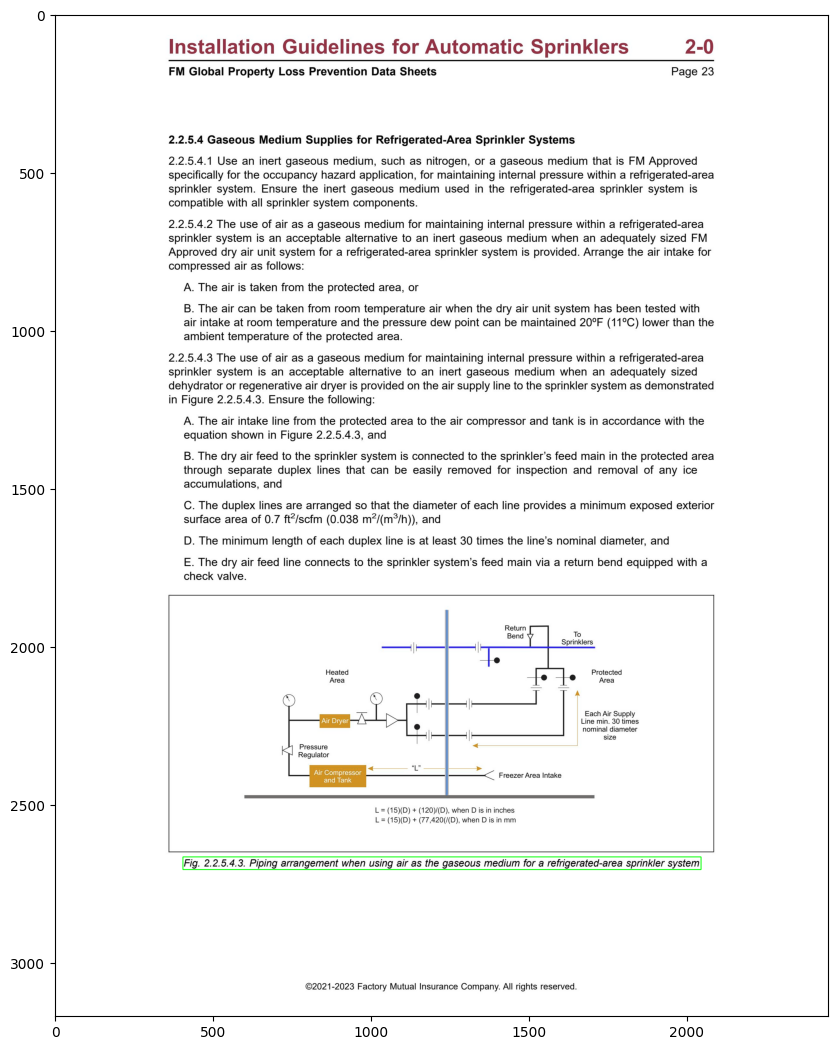

In [76]:
# I can draw a green rectangle around the text

def convert_inches_to_pixels(image, b_boxes):
    import cv2 
    import numpy as np
    # before I can draw a green box around the text
    # I must convert the coordinates from the ocr
    # which in inched on the pdf to pixels on the image    
    #
    # get the image size (h,w) in pixels
    image_height_in_pixels, image_width_in_pixels = image.shape[:2]
    print("image_width={}\timage_height={}".format(image_width_in_pixels, image_height_in_pixels))
    #
    image_coord_in_pixels=[]
    for point1,point2,point3,point4 in b_boxes:
        #convert the points to x, y
        x0,y0=point1.x,point1.y
        x1,y1=point2.x,point2.y
        x2,y2=point3.x,point3.y
        x3,y3=point4.x,point4.y
        # convert the inches to pixels
        # the formula is # (coordinate in inches/side in inches)*side in pixel = new coordinate in pixel 
        x0=int((x0/page_width_in_inches)*image_width_in_pixels)
        x1=int((x1/page_width_in_inches)*image_width_in_pixels)
        x2=int((x2/page_width_in_inches)*image_width_in_pixels)
        x3=int((x3/page_width_in_inches)*image_width_in_pixels)
        y0=int((y0/page_height_in_inches)*image_height_in_pixels)
        y1=int((y1/page_height_in_inches)*image_height_in_pixels)
        y2=int((y2/page_height_in_inches)*image_height_in_pixels)
        y3=int((y3/page_height_in_inches)*image_height_in_pixels)
        image_coord_in_pixels.append([(x0,y0),(x1,y1),(x2,y2),(x3,y3)])
    return image_coord_in_pixels

#    
# main code
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
image = cv2.imread("page_22.jpg")
page=result.pages[0]
# get the bounding boxes for the titeles on the pages (may be more than one)
b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)
# convert the inches to pixels    
image_coord_in_pixels = convert_inches_to_pixels(image, b_boxes)
# loop through and draw the rectangles around the titles
for b_box in image_coord_in_pixels:
    # convert the b_box to a list of tuples
    # this is what the cv2.rectangle function expects
    # b_box=[tup(point) for point in b_box]
    # draw the rectangle
    cv2.rectangle(image, b_box[0], b_box[2], (0, 255, 0), 2)
# show the image
plt.figure(figsize=(13,13))
plt.imshow(image)
plt.show()

# The text below the image is now hihglighted in green

#### To demostrate I can get the Image, I will draw a green box around it

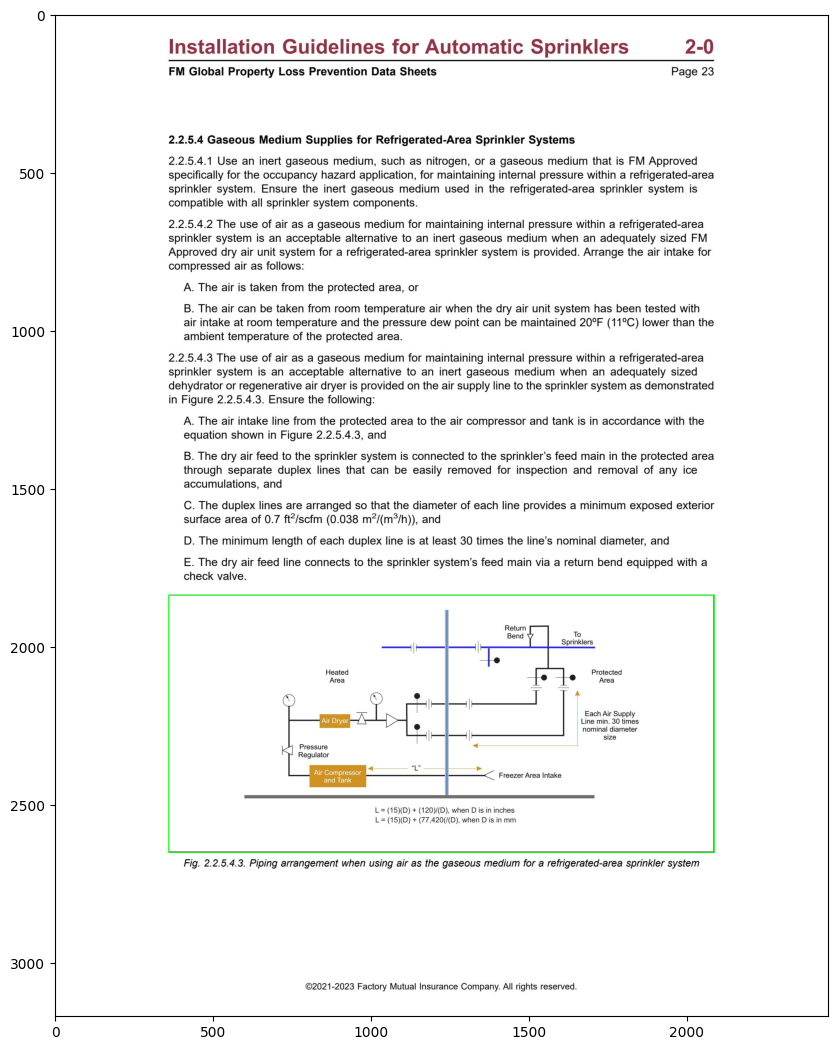

In [77]:
# main code
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
#
image = cv2.imread("page_22.jpg")
rectangles_out=get_rectangles(image)
# loop through and draw the rectangles around the titles
for x,y,w,h in rectangles_out:
    # convert the b_box to a list of tuples
    # this is what the cv2.rectangle function expects
    # b_box=[tup(point) for point in b_box]
    # draw the rectangle
    cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2)
# show the image
plt.figure(figsize=(13,13))
plt.imshow(image)
plt.show()

#### To Demonstrate I can get  both together and draw a single box around both

title_to_keep=2.2.5.4.3
image_width=2447	image_height=3168


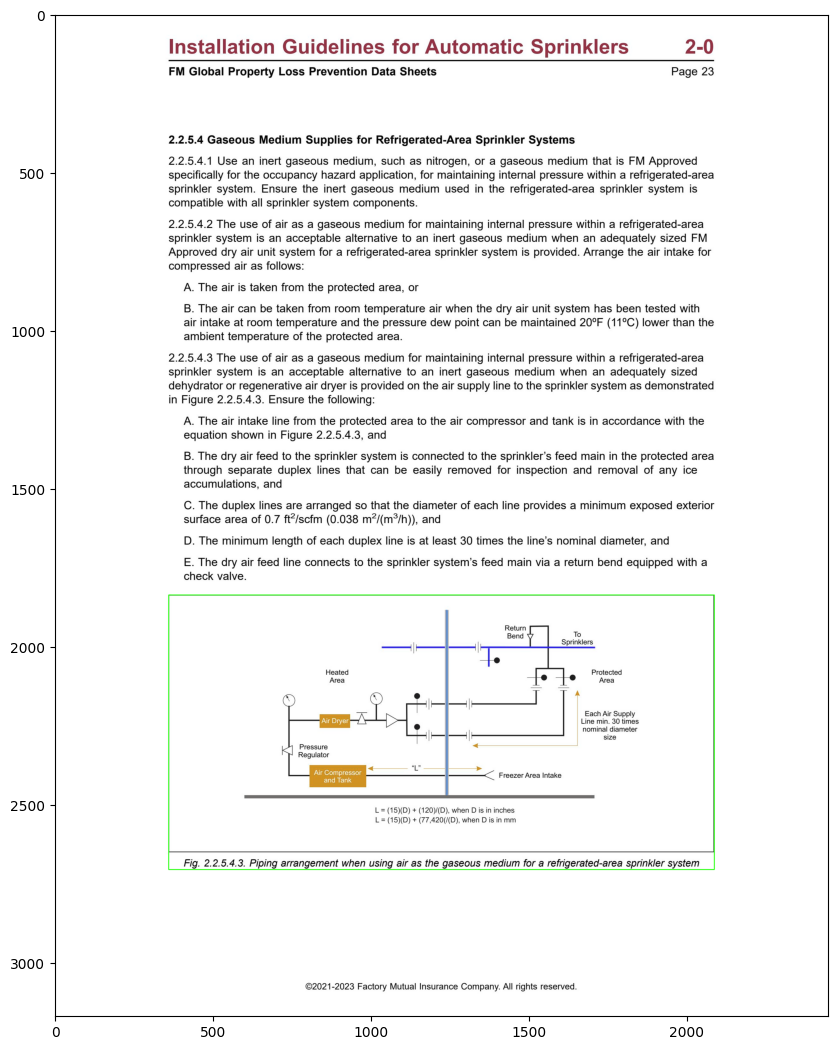

In [79]:
#
def draw_rect_around_both(image,page):
    import cv2 
    import numpy as np
    rectangles_out=get_rectangles(image)
    b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)    
    image_coord_in_pixels = convert_inches_to_pixels(image, b_boxes)
    #
    for x,y,w,h in rectangles_out:
        for b_box in image_coord_in_pixels:
            # draw a green rectanle onto the image
            # the bottom tight corner of the text is: b_box[2]
            x_bottom_right_title,y_bottom_right_title = b_box[2]
            # the top_left_corner of the title is: b_box[0]
            x_top_left_title,y_top_left_title = b_box[0]
            # tope left corner of the rectangle
            x_top_left_rect,y_top_left_rect = x,y
            # bottom right corner of the rectangle
            x_bottom_right_rect,y_bottom_right_rect = x+w,y+h
            # use the leftmost x cordinate of the two and
            # use the rightmost x cordinate of the two
            # and use the top y cordinage of the image
            # and use the bottom coordinate of the text
            x_top_left = min(x_top_left_title,x_top_left_rect)
            y_top_left = min(y_top_left_title,y_top_left_rect)
            x_bottom_right = max(x_bottom_right_title,x_bottom_right_rect)
            y_bottom_right = max(y_bottom_right_title,y_bottom_right_rect)
            # draw the rectangle
            cv2.rectangle(image,(x_top_left,y_top_left),(x_bottom_right,y_bottom_right),(36,255,12),2)
            # cv2.rectangle(image,(x,y),(x+w,y+h),(36,255,12),2)
    return image
 
    
# main code
import cv2 
import matplotlib.pyplot as plt
from matplotlib import rcParams
image = cv2.imread("page_22.jpg")
page=result.pages[0]
image = draw_rect_around_both(image, page)
# We are done drawing green rectangles
# on the image, lets show it
rcParams['figure.figsize'] = 13 ,13
plt.imshow(image)
plt.show() 

#### Instead of drawing green boxes, I will save the diagram and title as an image on disk

title_to_keep=2.2.5.4.3
image_width=2447	image_height=3168


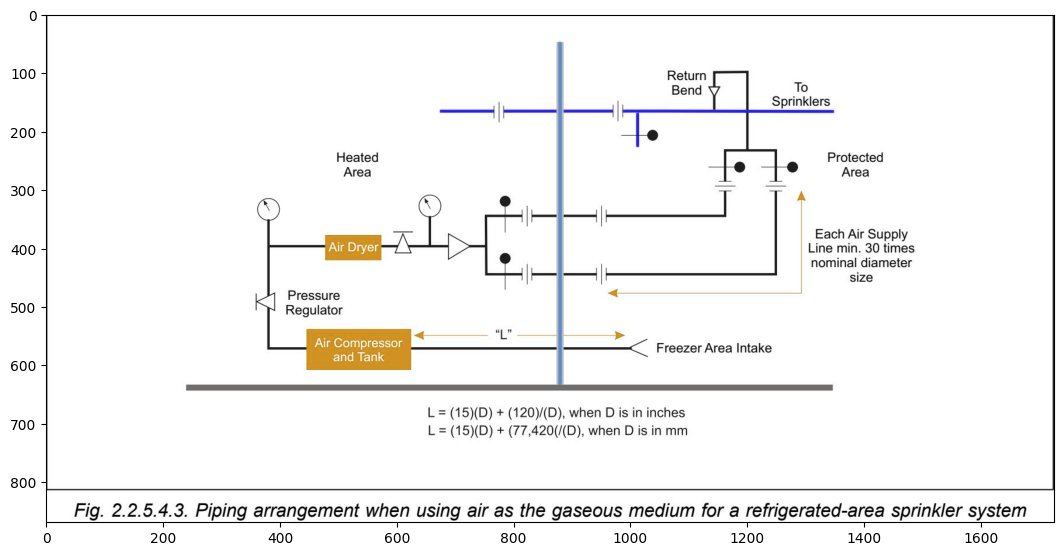

In [104]:
# This does almost the same as the previous code cell 
# except we want to cut out the images and save them
# to disk
# Also instead of using the bottom x value of the image 
# We want to use th elower x value of the text

#
def cutout_image_around_both(image, page):
    import cv2 
    import numpy as np
    cutouts=[]
    rectangles_out=get_rectangles(image)
    b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)    
    image_coord_in_pixels = convert_inches_to_pixels(image, b_boxes)
    #
    for x,y,w,h in rectangles_out:
        for b_box in image_coord_in_pixels:
            # cutout a rectanle onto the image
            # the bottom tight corner of the text is: b_box[2]
            x_bottom_right_title,y_bottom_right_title = b_box[2]
            # the top_left_corner of the title is: b_box[0]
            x_top_left_title,y_top_left_title = b_box[0]
            # tope left corner of the rectangle
            x_top_left_rect,y_top_left_rect = x,y
            # bottom right corner of the rectangle
            x_bottom_right_rect,y_bottom_right_rect = x+w,y+h
            # use the leftmost x cordinate of the two and
            # use the rightmost x cordinate of the two
            # and use the top y cordinage of the image
            # and use the bottom coordinate of the text
            x_top_left = min(x_top_left_title,x_top_left_rect)
            y_top_left = min(y_top_left_title,y_top_left_rect)
            x_bottom_right = max(x_bottom_right_title,x_bottom_right_rect)
            y_bottom_right = max(y_bottom_right_title,y_bottom_right_rect)
            # cutout the rectangle
            cutouts.append(image[y_top_left:y_bottom_right, x_top_left:x_bottom_right])
    # return the cutout images
    return cutouts, titles_to_keep
 
    
# main code
import cv2 
import matplotlib.pyplot as plt
from matplotlib import rcParams
#
image = cv2.imread("page_22.jpg")
page=result.pages[0]
#
# call the function to do the cutouts
cutouts_out, titles_to_keep = cutout_image_around_both(image,page)
#
# Now lets loop through the images and save them to disk
for image in cutouts_out:
    for title in titles_to_keep:
        # save it to disk
        final_title="Figure " + title + ".png"
        # write it to disk
        cv2.imwrite(str(final_title), image)
# loop through and show the images
for img in cutouts_out:
    plt.figure(figsize=(13,13))
    plt.imshow(img)
    plt.show()

#    

    
    